# Projet 3:  Concevez une application au service de la santé publique
--------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------

# P3_Part3 - Application
--------------------------------------------------------

# 1. Contexte
--------------------------------------

**Idée d'application**

----------------------------------------------------------------------------------------------

L'idée d'application, avec test de faisabilité, portera sur la similarité d'un produit recherché selon les caractéristiques des produits (energie,...).

La pré-prototype de l'application sera dans un premier temps, un moteur de recommandation : à partir de la recherche d'un produit, la liste des produits les plus sains classés par score (le nombre de g de protéines le plus faible possible, produit le plus sain donc nutri-score le plus bas) sera proposée, après interrogation du jeu de données nettoyés et imputés à partir de la base de données d'Open Food Facts.

**Objectif**

--------------------------------------------------------------------------------

Concevoir un pré-prototype de moteur de recommandation :

- préparation des variables.
- pré-traitement des noms de produits.
- version algorithmique d'un moteur de recommandation.

In [39]:
# Chargement des librairies
from IPython.core.display import display, HTML
import warnings
import re
import nltk
import datetime
import sys
#import jyquickhelper
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import fonctions_data
from thefuzz import fuzz
from thefuzz import process
from scipy.sparse import csr_matrix
from fuzzywuzzy import process
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
# Traitement de text
import texthero as hero
from texthero import preprocessing
import nltk
# Suppression affichage des futurs warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
# Chargement à chaud des librairies personnelles
%load_ext autoreload
%autoreload 2
# Valide code pep8
#%load_ext pycodestyle_magic
#%pycodestyle_on
#%pycodestyle_off

# Versions
print('Version des librairies utilisées :')
#print('jyquickhelper         : ' + jyquickhelper.__version__)
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Matplotlib            : ' + mpl.__version__)
print('Seaborn               : ' + sns.__version__)
print('Sklearn               : ' + sklearn.__version__)
print('Texthero              : 1.0.9')
print('Outils dataframe      : ' + fonctions_data.__version__)

now = datetime.datetime.now().isoformat()
print('Lancé le              : ' + now)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Version des librairies utilisées :
Python                : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
NumPy                 : 1.20.1
Pandas                : 1.2.4
Matplotlib            : 3.3.4
Seaborn               : 0.11.1
Sklearn               : 1.2.2
Texthero              : 1.0.9
Outils dataframe      : 0.0.0
Lancé le              : 2023-06-22T00:38:13.817055


In [2]:
# Chargement du jeu de données, séparateur = tabulation d'après la description des variables
data = pd.read_csv('cleaned_data.csv', sep='\t', index_col=0)
data

,url,product_name,image_small_url,main_category_fr,categories_tags,organic,energy_100g,nutrition_score_fr_100g,saturated_fat_100g,sugars_100g,proteins_100g,fat_100g,carbohydrates_100g,salt_100g,fiber_100g,nutrition_grade_fr
0,http://world-fr.openfoodfacts.org/produit/0000...,Salade Cesar,NaN,Légumes frais,"en:plant-based-foods-and-beverages,en:plant-ba...",NaN,0.0,6.0,7.000,0.000,22.000,12.00,23.00,2.16000,2.000,C
1,http://world-fr.openfoodfacts.org/produit/0000...,Chaussons tressés aux pommes,NaN,Pâtisseries,"en:sugary-snacks,en:biscuits-and-cakes,en:past...",NaN,0.0,9.0,2.000,24.700,3.330,10.70,38.70,0.64700,2.000,C
2,http://world-fr.openfoodfacts.org/produit/0000...,Pain Burger Artisan,NaN,Boulange,fr:boulange,NaN,0.0,1.0,0.333,1.110,10.000,1.11,53.30,1.52000,2.220,B
3,http://world-fr.openfoodfacts.org/produit/0000...,Quiche Lorraine,NaN,Plats préparés,"en:meals,en:pizzas-pies-and-quiches,en:quiches...",NaN,0.0,2.0,2.860,0.714,5.360,6.79,7.86,0.49900,0.357,B
4,http://world-fr.openfoodfacts.org/produit/0000...,Belgische Pralinen,NaN,Aliments et boissons à base de végétaux,"en:plant-based-foods-and-beverages,en:plant-ba...",False,0.0,26.0,21.100,51.500,4.700,33.30,53.80,0.09000,0.000,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56493,http://world-fr.openfoodfacts.org/produit/9609...,Santa Cruz Chilli & Lime Dressing,http://fr.openfoodfacts.org/images/products/96...,Epicerie,"en:groceries,en:sauces,en:salad-dressings",False,0.0,6.0,0.500,16.700,0.300,6.90,23.10,0.54102,0.600,C
56494,http://world-fr.openfoodfacts.org/produit/9611...,Fisherman's Friend Miel-Citron,NaN,Bonbons,"en:sugary-snacks,en:confectioneries,en:candies...",False,0.0,2.0,1.280,0.100,0.004,1.30,95.31,0.00100,1.470,B
56495,http://world-fr.openfoodfacts.org/produit/9778...,Nature cheddar and red onion crisps,NaN,Chips et frites,"en:salty-snacks,en:appetizers,en:chips-and-fri...",NaN,0.0,9.0,3.400,1.800,7.800,0.00,0.00,1.35000,5.600,C
56496,http://world-fr.openfoodfacts.org/produit/9847...,Tartines craquantes bio au sarrasin,http://fr.openfoodfacts.org/images/products/98...,Pains,"en:plant-based-foods-and-beverages,en:plant-ba...",True,0.0,-4.0,0.600,2.600,13.000,2.80,74.80,0.68000,5.900,A


## 2) Choix des variables de scoring

Les données utiles pour nos informations sont :

les nutriments répondants à une alimentation saine :
 - nutriscore
 - et équilibrée :
 - macro-nutriments (protéines (nutriment principal pour notre étude), lipides, glucide)
 - micro-nutriments (vitamines et minéraux)
 - la disponibilité des produits en France (pour une première phase puis extension dans les pays étrangers pour recommander des produits sur les lieux de vacances)

- les noms des produits, catégories, photos permettant de reconnaître le produit recommandé par le moteur de recommandation de notre application.

In [3]:
data.columns

Index(['url', 'product_name', 'image_small_url', 'main_category_fr',
       'categories_tags', 'organic', 'energy_100g', 'nutrition_score_fr_100g',
       'saturated_fat_100g', 'sugars_100g', 'proteins_100g', 'fat_100g',
       'carbohydrates_100g', 'salt_100g', 'fiber_100g', 'nutrition_grade_fr'],
      dtype='object')

In [4]:
# Dataframe de travail réduit
cols_a_garder = ['product_name', 'proteins_100g',
                  'nutrition_grade_fr', 'fat_100g',
                 'carbohydrates_100g', 'fiber_100g', 'salt_100g', 'energy_100g',
                 'url','image_small_url']
data_reduit = data[cols_a_garder]

<Figure size 216x216 with 0 Axes>

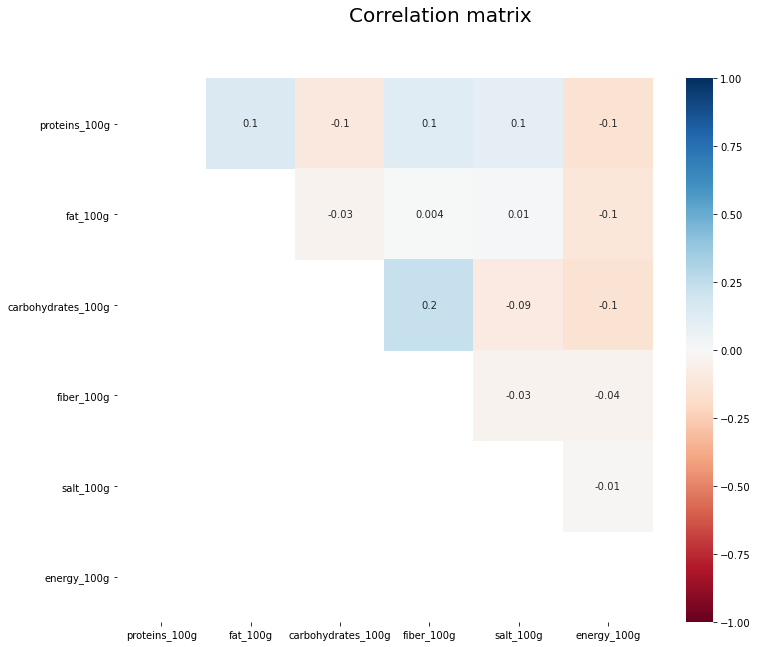

In [5]:
# Corrélation entre nos 2 principales variables de scoring
plt.figure(figsize=(3, 3))
correlation_matrix = data_reduit[cols_a_garder].corr(method='pearson')
triangular_matrix = np.tril(correlation_matrix)

fig, ax = plt.subplots(figsize=(12,10)) 
fig.suptitle("Correlation matrix", fontsize=20)
sns.heatmap(correlation_matrix, annot=True, fmt='.1g', mask=triangular_matrix, vmin=-1, vmax=1, cmap= 'RdBu')
plt.show()

### 2.1) Mise à l'échelle

On effectue cette méthode afin que les variables en question possèdent le meme poids.

In [6]:
cols_score = ['proteins_100g','fat_100g',
                 'carbohydrates_100g', 'fiber_100g', 'salt_100g']
df_score = data[cols_score]

In [7]:
# Statistiques descriptives des variables
fonctions_data.stat_descriptives(df_score)

,Variable name,Mean,Median,Skew,Kurtosis,Variance,Stdev,min,25%,50%,75%,max
0,proteins_100g,7.422809,5.8,1.844327,6.987238,54.728987,7.397904,0.0,1.60,5.8,10.1,93.1
1,fat_100g,12.636447,5.6,2.234466,6.497715,281.457428,16.776693,0.0,0.60,5.6,20.0,100.0
2,carbohydrates_100g,25.941620,12.9,0.786519,-0.811039,729.821426,27.015207,0.0,3.00,12.9,51.0,100.0
3,fiber_100g,1.695777,0.1,6.064252,76.899330,11.121771,3.334932,0.0,0.00,0.1,2.3,87.5
4,salt_100g,0.984538,0.5,21.766107,580.670243,11.337130,3.367066,0.0,0.07,0.5,1.2,100.0


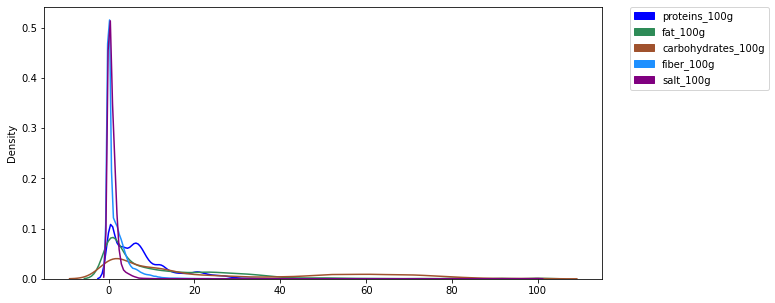

In [8]:
fonctions_data.plot_graph(df_score)

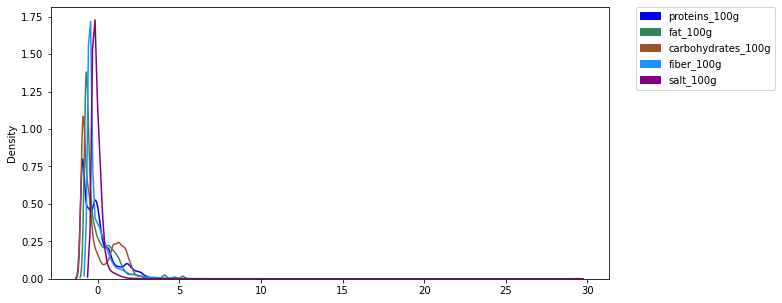

In [9]:
scaler_std = StandardScaler()
scaled_df_std = scaler_std.fit_transform(df_score)
scaled_df_std = pd.DataFrame(scaled_df_std, columns=cols_score)
fonctions_data.plot_graph(scaled_df_std)

In [10]:
# Statistiques descriptives des variables
fonctions_data.stat_descriptives(scaled_df_std)

,Variable name,Mean,Median,Skew,Kurtosis,Variance,Stdev,min,25%,50%,75%,max
0,proteins_100g,4.199301e-15,-0.219361,1.844327,6.987238,1.0,1.0,-1.003366,-0.787089,-0.219361,0.361885,11.581279
1,fat_100g,5.326390e-15,-0.419418,2.234466,6.497715,1.0,1.0,-0.753214,-0.717450,-0.419418,0.438916,5.207436
2,carbohydrates_100g,1.513873e-15,-0.482751,0.786519,-0.811039,1.0,1.0,-0.960260,-0.849211,-0.482751,0.927566,2.741359
3,fiber_100g,2.610619e-15,-0.478504,6.064252,76.899330,1.0,1.0,-0.508489,-0.508489,-0.478504,0.181180,25.728928
4,salt_100g,-4.432688e-16,-0.143905,21.766107,580.670243,1.0,1.0,-0.292402,-0.271613,-0.143905,0.063991,29.407049


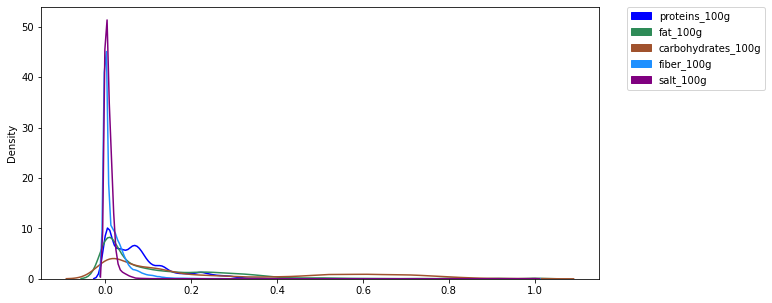

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler_min = MinMaxScaler()
scaled_df_min = scaler_min.fit_transform(df_score)
scaled_df_min = pd.DataFrame(scaled_df_min, columns=cols_score)
fonctions_data.plot_graph(scaled_df_min)

In [12]:
# Statistiques descriptives des variables
fonctions_data.stat_descriptives(scaled_df_min)

,Variable name,Mean,Median,Skew,Kurtosis,Variance,Stdev,min,25%,50%,75%,max
0,proteins_100g,0.079729,0.062299,1.844327,6.987238,0.006314,0.079462,0.0,0.017186,0.062299,0.108485,1.0
1,fat_100g,0.126364,0.056000,2.234466,6.497715,0.028146,0.167767,0.0,0.006000,0.056000,0.200000,1.0
2,carbohydrates_100g,0.259416,0.129000,0.786519,-0.811039,0.072982,0.270152,0.0,0.030000,0.129000,0.510000,1.0
3,fiber_100g,0.019380,0.001143,6.064252,76.899330,0.001453,0.038114,0.0,0.000000,0.001143,0.026286,1.0
4,salt_100g,0.009845,0.005000,21.766107,580.670243,0.001134,0.033671,0.0,0.000700,0.005000,0.012000,1.0


**Score**

In [24]:
df_score = data.copy()
df_score['Score'] = [(row[0] * 50 + row[1] * 2 + row[2] * 3  + row[3] * 5 + row[4] * 7) for row in zip(
    scaled_df_min['proteins_100g'], scaled_df_min['fat_100g'], scaled_df_min['carbohydrates_100g'], \
    scaled_df_min['fiber_100g'], scaled_df_min['salt_100g'])]

## 3) Pré-traitement des produits

### 3.1) Pré-processing

Le pipeline de nettoyage avec TEXTHERO est le suivant :

- fillna(s) Remplacer les valeurs non affectées par des espaces vides.
- lowercase(s) Tout le texte en minuscules.
- remove_digits() Supprimer tous les blocs de chiffres.
- remove_punctuation() Supprimer tous les string.punctuation (! "# $% & '() * +, -. / :; <=>? @ [] ^ _` {|} ~).
- remove_diacritics() Supprimer tous les accents des chaînes.
- remove_stopwords() Supprimer tous les mots vides (anglais uniquement).
- remove_whitespace() Supprimer tout espace blanc entre les mots.

In [25]:
df_score['nom_produit'] = hero.clean(df_score['product_name'])

In [26]:
df_score[['product_name', 'nom_produit']]

,product_name,nom_produit
0,Salade Cesar,salade cesar
1,Chaussons tressés aux pommes,chaussons tresses aux pommes
2,Pain Burger Artisan,pain burger artisan
3,Quiche Lorraine,quiche lorraine
4,Belgische Pralinen,belgische pralinen
...,...,...
56493,Santa Cruz Chilli & Lime Dressing,santa cruz chilli lime dressing
56494,Fisherman's Friend Miel-Citron,fisherman friend miel citron
56495,Nature cheddar and red onion crisps,nature cheddar red onion crisps
56496,Tartines craquantes bio au sarrasin,tartines craquantes bio au sarrasin


**NLTK**

Suppression des stopwords francais

In [27]:
stopwords_fr = set(nltk.corpus.stopwords.words('french'))
df_score['nom_produit'] = df_score['nom_produit'].apply(lambda words: ' '.join(
    word.lower() for word in words.split() if word not in stopwords_fr))

In [28]:
df_score[['product_name', 'nom_produit']]

,product_name,nom_produit
0,Salade Cesar,salade cesar
1,Chaussons tressés aux pommes,chaussons tresses pommes
2,Pain Burger Artisan,pain burger artisan
3,Quiche Lorraine,quiche lorraine
4,Belgische Pralinen,belgische pralinen
...,...,...
56493,Santa Cruz Chilli & Lime Dressing,santa cruz chilli lime dressing
56494,Fisherman's Friend Miel-Citron,fisherman friend miel citron
56495,Nature cheddar and red onion crisps,nature cheddar red onion crisps
56496,Tartines craquantes bio au sarrasin,tartines craquantes bio sarrasin


### 3.2) Vectorisation

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
count = TfidfVectorizer()
count.fit(df_score['nom_produit'])
count_matrix = count.transform(df_score['nom_produit'])

### 3.3) Données de comparaison

In [29]:
# Ajout de l'image de la note du nutri-score
df_score['image_nutri'] = ['https://static.openfoodfacts.org/images/attributes/nutriscore-a.svg' if row == 'A' else 'https://static.openfoodfacts.org/images/attributes/nutriscore-b.svg' if row == 'B' else 'https://static.openfoodfacts.org/images/attributes/nutriscore-c.svg' if row ==
                           'C' else 'https://static.openfoodfacts.org/images/attributes/nutriscore-d.svg' if row == 'D' else 'https://static.openfoodfacts.org/images/attributes/nutriscore-e.svg' for row in df_score['nutrition_grade_fr']]

In [31]:
# Ajout variables : lipides - Glucides - Sucre - Sel 
df_score['L_G_Su_Se'] = [(str(row[0]) + '-' + str(row[1]) + '-' + str(row[2]) + '-' + str(row[3])) for row in zip(
    df_score['fat_100g'], df_score['carbohydrates_100g'], df_score['sugars_100g'], df_score['salt_100g'])]

In [32]:
df_score.columns

Index(['url', 'product_name', 'image_small_url', 'main_category_fr',
       'categories_tags', 'organic', 'energy_100g', 'nutrition_score_fr_100g',
       'saturated_fat_100g', 'sugars_100g', 'proteins_100g', 'fat_100g',
       'carbohydrates_100g', 'salt_100g', 'fiber_100g', 'nutrition_grade_fr',
       'Score', 'nom_produit', 'image_nutri', 'L_G_Su_Se'],
      dtype='object')

In [33]:
# Renommage des variables
df_comparaison = df_score.filter(items=['product_name', 'image_small_url', 'proteins_100g',
                                        'image_nutri', 'nutrition_score_fr_100g','fat_100g','carbohydrates_100g','sugars_100g',\
                                        'salt_100g', 'L_G_Su_Se', 'Score'])
df_comparaison.set_index('product_name')
df_comparaison.rename(columns={'product_name': 'Produit',
                               'image_small_url': 'Photo',
                               'proteins_100g': 'g de protéines/100g prod',
                               'image_nutri': 'Note_nutri_score',
                               'nutrition_score_fr_100g': 'Nutri_score',
                               'fat_100g': 'g de matières grasses/100g prod',
                               'carbohydrates_100g': 'g de carbohydrates/100g prod',
                               'sugars_100g': 'g de sucres/100g prod',
                               'salt_100g': 'g de sel/100g prod'}, inplace=True)


In [34]:
cols_affich = ['Photo', 'g de protéines/100g prod', 'Note_nutri_score', 'Nutri_score', 'g de matières grasses/100g prod', \
               'g de carbohydrates/100g prod', 'g de sucres/100g prod', 'g de sel/100g prod', 'L_G_Su_Se']

In [35]:
df_comparaison.head()

,Produit,Photo,g de protéines/100g prod,Note_nutri_score,Nutri_score,g de matières grasses/100g prod,g de carbohydrates/100g prod,g de sucres/100g prod,g de sel/100g prod,L_G_Su_Se,Score
0,Salade Cesar,NaN,22.00,https://static.openfoodfacts.org/images/attrib...,6.0,12.00,23.00,0.000,2.160,12.0-23.0-0.0-2.16,13.010738
1,Chaussons tressés aux pommes,NaN,3.33,https://static.openfoodfacts.org/images/attrib...,9.0,10.70,38.70,24.700,0.647,10.7-38.7-24.7-0.647,3.322975
2,Pain Burger Artisan,NaN,10.00,https://static.openfoodfacts.org/images/attrib...,1.0,1.11,53.30,1.110,1.520,1.11-53.3-1.11-1.52,7.225026
3,Quiche Lorraine,NaN,5.36,https://static.openfoodfacts.org/images/attrib...,2.0,6.79,7.86,0.714,0.499,6.79-7.86-0.714-0.499,3.305555
4,Belgische Pralinen,NaN,4.70,https://static.openfoodfacts.org/images/attrib...,26.0,33.30,53.80,51.500,0.090,33.3-53.8-51.5-0.09,4.810468


## 4) Version algorithmique du moteur de recommendation

### 4.1) Par mot clé

In [40]:
def path_to_image_photo_html(path):
    return '<img src="' + path + ' " width="100">'


def path_to_image_nutri_html(path):
    return '<img src="' + path + ' " width="80">'

In [41]:
def rech_produits(prod_saisi, results_number=10):
    
    
    if (type(prod_saisi) != str) or (len(prod_saisi) <= 2):
        return print('Le produit saisi doit être un texte contenant plus de 2 caractères')

    results = []
    # Suppression de la ponctuation, minuscule
    prod_saisi = fonctions_data.suppr_ponct(prod_saisi)
    # Suppression des stopswords
    prod_saisi = ' '.join(word.lower()
                          for word in prod_saisi.split() if word not in stopwords_fr)
    # Vectorisation
    vector_prod = count.transform([prod_saisi])
    print("Produits recommandés : ")
    results.append(cosine_similarity(vector_prod, count_matrix))
    results = pd.Series(results).sort_values(ascending=False)
    elem_list = []
    for i in results:
        for elem in i[0]:
            elem_list.append(elem)
        # Ajout des similarités
        df_comparaison['Similarité'] = elem_list
        # Récupération des index des élements
        liste_produits = pd.Series(elem_list).sort_values(ascending=False)
        liste_produits = liste_produits.iloc[0:results_number].index
        # Récupération des produits correspondant aux index du df_comparaison
        top_produits = df_comparaison.iloc[liste_produits]
        top_produits.set_index('Produit', inplace=True)
        top_produits = top_produits.sort_values(by='Score')
        if max(top_produits['Similarité']) == 0.00000:
            return print('Aucun produit trouvé')

        df_prod = top_produits[cols_affich]
    # Affichage des images : photos, nutri-score
    pd.set_option('display.max_colwidth', None)
    print('Remarque : L_G_Su_Se : lipides - Glucides - Sucre - Sel')

    return display(HTML(df_prod.to_html(escape=False, formatters=dict(Photo=path_to_image_photo_html, Note_nutri_score=path_to_image_nutri_html))))
    

### 4.1) Recommendation par caractéristiques produits

Une variante de produits est proposé (type de produits, et ses caractéristiques nutritionnelles) selon le nom du produit 

In [42]:

def get_reco_by_features(product_name,n_recommendations):
    
    
    if (type(product_name) != str) or (len(product_name) <= 2):
        return print('Le produit saisi doit être un texte contenant plus de 2 caractères')

    # Suppression de la ponctuation, minuscule
    product_name = fonctions_data.suppr_ponct(product_name)
    # Suppression des stopswords
    product_name = ' '.join(word.lower()
                          for word in product_name.split() if word not in stopwords_fr)
    
    product_nut = df_comparaison.copy()
    product_nut = product_nut[['Produit','Nutri_score','g de matières grasses/100g prod','g de carbohydrates/100g prod', \
             'g de sucres/100g prod', 'g de sel/100g prod']]
    product_nut = product_nut.set_index('Produit')
    mat_product_nut=csr_matrix(product_nut.values) 
    
#  Moteur de recommendation KNN, avec pour metrique de similarité, le cosinus
    model_knn= NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
    model_knn.fit(mat_product_nut)
    df_c = df_comparaison.copy()
    idx=process.extractOne(product_name, df_c['Produit'])[2]
    
    print('Produit séléctionné: ',df_c['Produit'][idx], 'Index: ',idx)
    print('Recherche de recommendations.....')
    distances, indices = model_knn.kneighbors(mat_product_nut[idx], n_neighbors=n_recommendations)
    df_c = df_c.iloc[indices.flatten().tolist(),:]
    top_produits = df_c.sort_values(by='Score', ascending=False)

    pd.set_option('display.max_colwidth', None)
    print('Remarque : L_G_Su_Se : lipides - Glucides - Sucre - Sel')

    return display(HTML(top_produits.to_html(escape=False, formatters=dict(Photo=path_to_image_photo_html, Note_nutri_score=path_to_image_nutri_html))))
   

**Test moteur (version caracteristiques produit)**

In [54]:
get_reco_by_features('lentilles',20)

Produit séléctionné:  Lentilles  Index:  4217
Recherche de recommendations.....
Remarque : L_G_Su_Se : lipides - Glucides - Sucre - Sel


,Produit,Photo,g de protéines/100g prod,Note_nutri_score,Nutri_score,g de matières grasses/100g prod,g de carbohydrates/100g prod,g de sucres/100g prod,g de sel/100g prod,L_G_Su_Se,Score
55481,Haricots rouges kidney,,8.9,,-6.0,0.4,15.0,1.00,0.80000,0.4-15.0-1.0-0.8,5.693807
35245,Haricots rouges,,8.7,,-7.0,0.5,15.4,0.30,0.59944,0.5-15.4-0.3-0.59944,5.609213
5115,Haricots rouges,,8.3,,-8.0,0.7,20.0,0.60,0.43180,0.7-20.0-0.6-0.4318,5.478941
38197,Haricots rouges,,8.1,,-6.0,0.6,15.0,0.90,0.71120,0.6-15.0-0.9-0.7112,5.147659
9046,Haricots rouges cuisinés,NaN,7.7,,-5.0,0.7,13.3,0.70,0.78000,0.7-13.3-0.7-0.78,4.962938
19384,Lentilles préparées,,6.9,,-5.0,0.6,11.6,0.40,0.83820,0.6-11.6-0.4-0.8382,4.375795
36444,Haricots blancs prėparės,,6.5,,-5.0,0.7,12.0,0.70,0.80000,0.7-12.0-0.7-0.8,4.292299
9078,Cassegrain Lentilles Cuisinées,NaN,6.6,,-5.0,0.3,11.7,0.00,0.88000,0.3-11.7-0.0-0.88,4.208890
2413,Haricots blancs,,6.4,,-5.0,0.6,11.0,0.30,0.68000,0.6-11.0-0.3-0.68,4.203907
43418,Weiße Bohnen mit Suppengrün,,6.4,,-5.0,0.6,11.0,0.30,0.68000,0.6-11.0-0.3-0.68,4.203907


In [53]:
get_reco_by_features('boite de thé',15)

Produit séléctionné:  Thé Index:  8617
Recherche de recommendations.....
Remarque : L_G_Su_Se : lipides - Glucides - Sucre - Sel


,Produit,Photo,g de protéines/100g prod,Note_nutri_score,Nutri_score,g de matières grasses/100g prod,g de carbohydrates/100g prod,g de sucres/100g prod,g de sel/100g prod,L_G_Su_Se,Score
46975,Nestea Mangue Ananas,,0.0,,7.0,0.0,4.60,4.60,0.050800,0.0-4.6-4.6-0.0508,0.141556
47030,Thé glacé saveur Tropical,,0.0,,7.0,0.0,4.60,4.60,0.040000,0.0-4.6-4.6-0.04,0.140800
46906,Thé glacé saveur citron,,0.0,,7.0,0.0,4.60,4.60,0.039878,0.0-4.6-4.6-0.039878,0.140791
46951,Nalu,,0.0,,7.0,0.0,4.60,4.60,0.025400,0.0-4.6-4.6-0.0254,0.139778
46902,Thé glacé saveur Citron,,0.0,,7.0,0.0,4.55,4.55,0.039400,0.0-4.55-4.55-0.0394,0.139258
47001,"Vitaminwater xxx - 3 baies (vitamines b + c), açaï - myrtille - grenade",,0.0,,7.0,0.0,4.60,4.60,0.000000,0.0-4.6-4.6-0.0,0.138000
47028,Finley Citrons & Fleur de sureau,,0.0,,7.0,0.0,4.60,4.60,0.000000,0.0-4.6-4.6-0.0,0.138000
47022,Finley Pamplemousse & Orange sanguine,,0.0,,7.0,0.0,4.60,4.60,0.000000,0.0-4.6-4.6-0.0,0.138000
47025,Pamplemousse & Orange sanguine,,0.0,,7.0,0.0,4.60,4.60,0.000000,0.0-4.6-4.6-0.0,0.138000
47023,Pamplemousse & orange sanguine,,0.0,,7.0,0.0,4.60,4.60,0.000000,0.0-4.6-4.6-0.0,0.138000


In [45]:
get_reco_by_features('Soja',15)

Produit séléctionné:  Soja Index:  27720
Recherche de recommendations.....
Remarque : L_G_Su_Se : lipides - Glucides - Sucre - Sel


,Produit,Photo,g de protéines/100g prod,Note_nutri_score,Nutri_score,g de matières grasses/100g prod,g de carbohydrates/100g prod,g de sucres/100g prod,g de sel/100g prod,L_G_Su_Se,Score
30208,Spiruline,,67.0,,-1.0,6.80,14.0,0.001,0.0000,6.8-14.0-0.001-0.0,36.538814
27720,Soja,,32.0,,-3.0,16.20,36.2,0.000,0.0000,16.2-36.2-0.0-0.0,19.338679
40086,Knäckebrot Backmischung,,16.0,,-3.0,21.00,42.0,0.500,0.0400,21.0-42.0-0.5-0.04,10.835711
1334,Casino filet de merlan pané,,13.6,,-2.0,8.80,20.0,0.880,0.3450,8.8-20.0-0.88-0.345,8.168124
37011,4 Tranches Panées de Cabillaud,,13.0,,-1.0,6.70,16.0,0.500,0.5500,6.7-16.0-0.5-0.55,7.674240
37013,100 % filet cabillaud,,13.0,,-1.0,6.50,16.0,0.300,0.5080,6.5-16.0-0.3-0.508,7.667300
30465,Petits poissons panés,,11.9,,-2.0,8.30,20.1,0.600,0.6000,8.3-20.1-0.6-0.6,7.270549
37015,"Colin Lieu ou d'Alaska, Surgelés",,12.0,,-1.0,6.50,16.0,0.300,0.6350,6.5-16.0-0.3-0.635,7.139133
30464,Filets de Colin d'Alaska Panés,,11.6,,-2.0,8.90,20.6,0.800,0.4600,8.9-20.6-0.8-0.46,7.120918
1165,Fish Sticks,,11.4,,-1.0,7.89,17.5,0.000,0.5350,7.89-17.5-0.0-0.535,6.892813


In [55]:
get_reco_by_features('oeufs',20)

Produit séléctionné:  Oeufs Index:  28969
Recherche de recommendations.....
Remarque : L_G_Su_Se : lipides - Glucides - Sucre - Sel


,Produit,Photo,g de protéines/100g prod,Note_nutri_score,Nutri_score,g de matières grasses/100g prod,g de carbohydrates/100g prod,g de sucres/100g prod,g de sel/100g prod,L_G_Su_Se,Score
47796,Karbonadedeig,NaN,22.1,,-2.0,5.00,0.0,0.00,0.100000,5.0-0.0-0.0-0.1,11.975958
11804,L'Authentique Façon Bouchère 5% M.G.,,21.1,,-2.0,5.00,0.0,0.00,0.200000,5.0-0.0-0.0-0.2,11.445901
11799,Petit appétit 2 steaks hachés 5% pur boeuf,,21.1,,-2.0,5.00,0.0,0.00,0.200000,5.0-0.0-0.0-0.2,11.445901
11794,1 steak haché pur boeuf 5% M.G,,21.1,,-2.0,5.00,0.0,0.00,0.199898,5.0-0.0-0.0-0.199898,11.445894
37683,Le 100% Pur Bœuf (5% MG),,21.0,,-2.0,5.00,0.0,0.00,0.200000,5.0-0.0-0.0-0.2,11.392195
13278,10 steaks hachés pur bœuf,,21.0,,-2.0,5.00,0.0,0.00,0.150000,5.0-0.0-0.0-0.15,11.388695
13543,Le Pur Bœuf 5% de M.G.,NaN,20.5,,-2.0,5.00,0.0,0.00,0.180000,5.0-0.0-0.0-0.18,11.122267
3725,British pork lean mince,,20.2,,-2.0,5.80,0.1,0.10,0.152400,5.8-0.1-0.1-0.1524,10.978218
21889,Pavés de Saumon,NaN,20.0,,-3.0,8.60,0.2,0.00,0.090000,8.6-0.2-0.0-0.09,10.925439
20049,Steaks hachés pur boeuf 5% MG,,20.0,,-2.0,5.00,0.5,0.00,0.150114,5.0-0.5-0.0-0.150114,10.866647


In [56]:
get_reco_by_features('confiture',20)

Produit séléctionné:  Confiture Mûre Index:  32324
Recherche de recommendations.....
Remarque : L_G_Su_Se : lipides - Glucides - Sucre - Sel


,Produit,Photo,g de protéines/100g prod,Note_nutri_score,Nutri_score,g de matières grasses/100g prod,g de carbohydrates/100g prod,g de sucres/100g prod,g de sel/100g prod,L_G_Su_Se,Score
34043,Miel d'Oranger d'Espagne,,1.0,,13.0,0.00,78.0,78.0,0.03556,0.0-78.0-78.0-0.03556,2.879546
46543,Miel,,0.5,,13.0,0.10,79.3,79.3,0.01500,0.1-79.3-79.3-0.015,2.690578
45994,Meli,,0.5,,13.0,0.01,79.3,79.3,0.01524,0.01-79.3-79.3-0.01524,2.648795
51604,Miel d'Oranger de Sicile et Calabrie Bio,,0.3,,14.0,0.00,82.5,82.5,0.00000,0.0-82.5-82.5-0.0,2.636117
51602,Miel Toutes Fleurs,,0.3,,14.0,0.00,82.5,82.5,0.00000,0.0-82.5-82.5-0.0,2.636117
51603,Miel italien de fleurs de Sainfoin,,0.3,,14.0,0.00,82.5,82.5,0.00000,0.0-82.5-82.5-0.0,2.636117
51415,Miele Millefiori Piana squizz PIANAMIELE,,0.4,,13.0,0.00,78.0,78.0,0.00000,0.0-78.0-78.0-0.0,2.554823
42930,Hollala Sirup Pfefferminze,,0.1,,14.0,0.10,82.6,82.5,0.00200,0.1-82.6-82.5-0.002,2.539560
55578,Water Mix saveur Mandarine Pêche,NaN,0.0,,14.0,0.00,83.0,83.0,0.00000,0.0-83.0-83.0-0.0,2.490000
15303,Sirop de framboise,,0.1,,13.0,0.10,78.0,78.0,0.02540,0.1-78.0-78.0-0.0254,2.426055


**Test moteur (version mot 'clé')**

In [166]:
# test du pré-moteur - 1 caractère saisi, nombre entier
produit = input(str('Quel est le produit recherché ? : '))
rech_produits(produit)

Quel est le produit recherché ? : lentilles
Produits recommandés : 
Remarque : L_G_Su_Se : lipides - Glucides - Sucre - Sel


,Photo,g de protéines/100g prod,Note_nutri_score,Nutri_score,g de matières grasses/100g prod,g de carbohydrates/100g prod,g de sucres/100g prod,g de sel/100g prod,L_G_Su_Se
Produit,,,,,,,,,
Lentilles,,6.0,,0.0,0.4,12.0,0.4,0.55118,0.4-12.0-0.4-0.55118
Lentilles,,6.0,,-5.0,0.2,11.4,0.3,0.57700,0.2-11.4-0.3-0.577
Lentilles,,6.0,,-4.0,0.2,11.4,0.3,0.88000,0.2-11.4-0.3-0.88
Lentilles,,6.1,,-3.0,0.4,12.0,0.4,0.95000,0.4-12.0-0.4-0.95
Lentilles,,6.1,,-8.0,0.4,12.0,0.4,0.95000,0.4-12.0-0.4-0.95
Lentilles,,6.1,,-3.0,0.4,12.0,0.4,0.95000,0.4-12.0-0.4-0.95
Lentilles,,6.3,,-5.0,0.5,12.0,0.5,0.58000,0.5-12.0-0.5-0.579999999999999
Lentilles,,7.2,,-5.0,0.4,14.2,1.0,0.70000,0.4-14.2-1.0-0.699999999999999
Lentilles,,7.2,,-4.0,0.8,17.0,0.6,1.00000,0.8-17.0-0.6-1.0


In [65]:
# test du pré-moteur - 1 caractère saisi, nombre entier
produit = input(str('Quel est le produit recherché ? : '))
rech_produits(produit)

Quel est le produit recherché ? : Soja
Produits recommandés : 
Remarque : L_G_Su_Se : lipides - Glucides - Sucre - Sel


,Photo,g de protéines/100g prod,Note_nutri_score,Nutri_score,g de matières grasses/100g prod,g de carbohydrates/100g prod,g de sucres/100g prod,g de sel/100g prod,L_G_Su_Se
Produit,,,,,,,,,
"Soja, Boisson soja nature",,3.2,,-1.0,1.8,2.0,1.7,0.0500,1.8-2.0-1.7-0.05
soja chocolat,,3.4,,-2.0,1.9,8.2,7.8,0.1778,1.9-8.2-7.8-0.1778
"Soja, Boisson au Soja chocolat",,3.4,,-2.0,2.0,9.8,9.0,0.1000,2.0-9.8-9.0-0.1
Soja chocolat,NaN,3.5,,16.0,2.0,9.8,9.2,0.0100,2.0-9.8-9.2-0.01
So Soja ! Chocolat,NaN,3.5,,1.0,1.9,17.5,12.6,0.1500,1.9-17.5-12.6-0.15
Soja Chocolat,NaN,4.0,,-2.0,3.0,8.7,8.0,0.1200,3.0-8.7-8.0-0.12
Soja Chocolat,NaN,3.5,,-1.0,2.1,18.0,16.0,0.1000,2.1-18.0-16.0-0.1
Soja au Chocolat,,3.5,,-1.0,2.1,18.2,15.2,0.1000,2.1-18.2-15.2-0.1
Sauce soja,,8.6,,4.0,0.1,5.3,1.4,20.3000,0.1-5.3-1.4-20.3


In [66]:
# test du pré-moteur - 1 caractère saisi, nombre entier
produit = input(str('Quel est le produit recherché ? : '))
rech_produits(produit)

Quel est le produit recherché ? : oeufs
Produits recommandés : 
Remarque : L_G_Su_Se : lipides - Glucides - Sucre - Sel


,Photo,g de protéines/100g prod,Note_nutri_score,Nutri_score,g de matières grasses/100g prod,g de carbohydrates/100g prod,g de sucres/100g prod,g de sel/100g prod,L_G_Su_Se
Produit,,,,,,,,,
Œufs 5,NaN,12.5,,-1.0,0.00,0.0,0.08,0.32000,0.0-0.0-0.08-0.32
Biscuits aux oeufs,,8.0,,11.0,3.00,76.0,40.00,0.25000,3.0-76.0-40.0-0.25
20 oeufs frais,NaN,12.6,,-4.0,0.00,0.0,0.22,0.00000,0.0-0.0-0.22-0.0
Oeufs frais,,12.3,,-1.0,10.00,0.7,0.70,0.29972,10.0-0.7-0.7-0.29972
6 œufs frais,,12.3,,-1.0,10.00,0.7,0.70,0.30000,10.0-0.7-0.7-0.3
10 œufs Bio,,12.3,,-1.0,10.30,0.7,0.70,0.32000,10.3-0.7-0.7-0.32
Oeufs,,12.6,,-4.0,9.86,0.8,0.22,0.00000,9.86-0.8-0.22-0.0
Oeufs,,12.6,,-1.0,9.90,0.8,0.80,0.33000,9.9-0.8-0.8-0.33
Œufs,,12.6,,-1.0,9.90,0.8,0.80,0.33020,9.9-0.8-0.8-0.3302


In [67]:
# test du pré-moteur - 1 caractère saisi, nombre entier
produit = input(str('Quel est le produit recherché ? : '))
rech_produits(produit)

Quel est le produit recherché ? : confiture
Produits recommandés : 
Remarque : L_G_Su_Se : lipides - Glucides - Sucre - Sel


,Photo,g de protéines/100g prod,Note_nutri_score,Nutri_score,g de matières grasses/100g prod,g de carbohydrates/100g prod,g de sucres/100g prod,g de sel/100g prod,L_G_Su_Se
Produit,,,,,,,,,
Confiture Orange,,0.46,,13.0,0.0,0.0,62.7,0.0200,0.0-0.0-62.7-0.02
Confiture bio,,0.50,,10.0,0.0,58.0,58.0,0.0762,0.0-58.0-58.0-0.0762
Confiture 4 Fruits,,0.50,,10.0,0.2,58.0,52.9,0.0180,0.2-58.0-52.9-0.018
Confiture 4 fruits,,0.50,,10.0,0.1,58.0,58.0,0.0000,0.1-58.0-58.0-0.0
Confiture 4 Fruits,NaN,0.50,,10.0,0.1,58.0,58.0,0.0000,0.1-58.0-58.0-0.0
Confiture de lait,NaN,5.80,,21.0,0.0,0.0,37.0,0.2000,0.0-0.0-37.0-0.2
Confiture de lait,,3.40,,16.0,3.7,65.0,52.0,0.6500,3.7-65.0-52.0-0.65
Confiture de lait,,6.00,,20.0,13.3,40.9,36.6,0.1900,13.3-40.9-36.6-0.19
Confiture de Lait,,7.70,,14.0,3.6,57.0,51.0,0.3500,3.6-57.0-51.0-0.35
